In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def data_prep():
    # read the D3 dataset
    df = pd.read_csv('D3.csv')

    #Correct data types for admission_type_id, discharge_disposition_id, admission_source_id
    #Changto interval/integer to nominal/str
    df['admission_type_id'] = df['admission_type_id'].astype(str)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str)
    df['admission_source_id'] = df['admission_source_id'].astype(str)

    # impute missing values using mode
    df['race'].fillna(df['race'].mode()[0], inplace=True)
    df['age'].fillna(df['age'].mode()[0], inplace=True)
    df['chlorpropamide'].fillna(df['chlorpropamide'].mode()[0], inplace=True)

    #Mapping age group into numeric
    age_map = {'[0-10)': 1, '[10-20)': 2, '[20-30)': 3,'[30-40)': 4,'[40-50)': 5,
               '[50-60)': 6,'[60-70)': 7,'[70-80)': 8,'[80-90)': 9,'[90-100)': 10}
    df['age'] = df['age'].map(age_map)

    # one-hot encoding
    df = pd.get_dummies(df)

    return df
df = data_prep()

# target/input split
y = df['readmitted']
X = df.drop(['readmitted'], axis=1)
X_mat = X.to_numpy()

#Training/test distribution split
from sklearn.model_selection import train_test_split
# setting random state
rs = 10
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51766 entries, 0 to 51765
Columns: 160 entries, age to insulin_Up
dtypes: bool(2), int64(10), uint8(148)
memory usage: 11.4 MB


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

def tree_eval(model):
    #a/ What is the classification accuracy of training and test datasets?
    print("a) Train accuracy:", model.score(X_train, y_train))
    print("   Test accuracy:", model.score(X_test, y_test))

    #------------------------------------------------------------------------------------------------------------------------------
    #b/ What is the size of the tree (number of nodes and rules/leaves)?
    print("\nb) Number of nodes: ",model.tree_.node_count)
    leaf_nodes_count = 0
    for node in model.tree_.children_left:
        if node == -1:
            leaf_nodes_count = leaf_nodes_count + 1
    print("   Number of rules: ",leaf_nodes_count)
    print("   Depth of the decision tree: ",model.tree_.max_depth)

    #------------------------------------------------------------------------------------------------------------------------------
    #c/ Which variable is used for the first split?
    feature_names = X.columns
    print("\nc) Variable is used for the first split: ",feature_names[model.tree_.feature[0]])
    #------------------------------------------------------------------------------------------------------------------------------
    #d/ What are the 5 important variables (in the order) in building the tree?
    # grab feature importances from the model and feature name from the original X
    importances = model.feature_importances_

    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 5 features
    indices = indices[:15]
    print("\nd) The most important variables: ")
    order = 1
    for i in indices:
        print('   ',order,'/',feature_names[i], ':', importances[i])
        order = order + 1
    #------------------------------------------------------------------------------------------------------------------------------
    #e/ What parameters have been used in building the tree? Detail them.
    print("\ne) Hyperparameters:")
    print(model.get_params(deep=True))

#2/ Default decision tree
rs = 10
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)
print("2/Default decision tree--------------------------------")
tree_eval(model)

2/Default decision tree--------------------------------
a) Train accuracy: 1.0
   Test accuracy: 0.5685125563425628

b) Number of nodes:  19591
   Number of rules:  9796
   Depth of the decision tree:  47

c) Variable is used for the first split:  number_inpatient

d) The most important variables: 
    1 / num_lab_procedures : 0.14896074289093125
    2 / num_medications : 0.12148182068657452
    3 / time_in_hospital : 0.07629595262806733
    4 / number_inpatient : 0.0673755677768508
    5 / age : 0.05062731077545103
    6 / num_procedures : 0.049565848574791585
    7 / number_diagnoses : 0.04299671230929224
    8 / number_outpatient : 0.02352152760444628
    9 / discharge_disposition_id_11 : 0.015548490495376495
    10 / number_emergency : 0.015191975200382603
    11 / gender_Female : 0.0142739279806649
    12 / discharge_disposition_id_6 : 0.01341917153651273
    13 / discharge_disposition_id_1 : 0.01216472647048269
    14 / change : 0.012081030563886444
    15 / gender_Male : 0.01175

In [3]:
# grid search CV
from sklearn.model_selection import GridSearchCV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 48, 5)[1:],
          'min_samples_leaf': range(100, 500, 50)[1:]}

cv_model = GridSearchCV(param_grid=params,
                        estimator=DecisionTreeClassifier(random_state=rs),
                        return_train_score=True, cv=10, n_jobs = -1)
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 200}

In [4]:
# grid search CV
from sklearn.model_selection import GridSearchCV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(3, 9, 1)[1:],
          'min_samples_leaf': range(150, 250, 20)[1:]}

cv_model = GridSearchCV(param_grid=params,
                        estimator=DecisionTreeClassifier(random_state=rs),
                        return_train_score=True, cv=10, n_jobs = -1)
cv_model.fit(X_train, y_train)
cv_model.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 170}

In [5]:
#3/ Optimal decision tree
optimal_model = cv_model.best_estimator_
print("3/Optimal decision tree--------------------------------")
tree_eval(optimal_model)

3/Optimal decision tree--------------------------------
a) Train accuracy: 0.6417650954851529
   Test accuracy: 0.6381197681905988

b) Number of nodes:  103
   Number of rules:  52
   Depth of the decision tree:  7

c) Variable is used for the first split:  number_inpatient

d) The most important variables: 
    1 / number_inpatient : 0.5769756728766813
    2 / discharge_disposition_id_11 : 0.13930703342964007
    3 / age : 0.05054118464481738
    4 / number_emergency : 0.04939216371974154
    5 / number_outpatient : 0.03552844666217202
    6 / diabetesMed : 0.026924087801878015
    7 / admission_type_id_3 : 0.017809235425481528
    8 / number_diagnoses : 0.015365596446906556
    9 / num_medications : 0.013573613048768668
    10 / medical_specialty_InternalMedicine : 0.013538809892010624
    11 / time_in_hospital : 0.0123252254821434
    12 / admission_source_id_7 : 0.01137767417156676
    13 / num_procedures : 0.010171449173901781
    14 / medical_specialty_Invalid : 0.007160533951341

Classification report of default decision tree:
              precision    recall  f1-score   support

           0     0.6014    0.5946    0.5980      8382
           1     0.5309    0.5379    0.5344      7148

    accuracy                         0.5685     15530
   macro avg     0.5661    0.5663    0.5662     15530
weighted avg     0.5689    0.5685    0.5687     15530

Classification report of optimal decision tree:
              precision    recall  f1-score   support

           0     0.6446    0.7343    0.6866      8382
           1     0.6277    0.5253    0.5720      7148

    accuracy                         0.6381     15530
   macro avg     0.6362    0.6298    0.6293     15530
weighted avg     0.6368    0.6381    0.6338     15530

ROC index on test for DT_default: 0.5662600975496164
ROC index on test for DT_optimal: 0.678435855699525


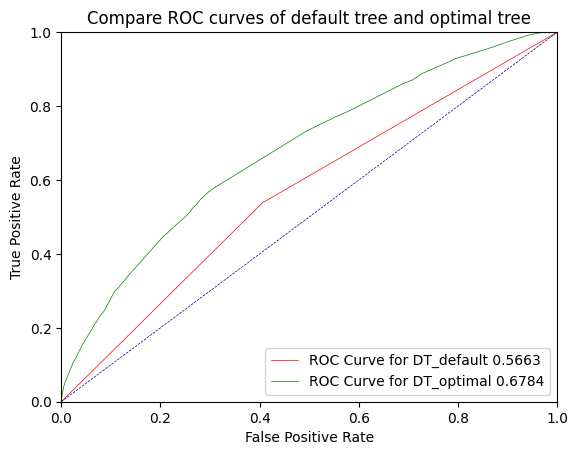

In [6]:
#4 Performace comparison
y_pred_default_dt = model.predict(X_test)
print("Classification report of default decision tree:")
print(classification_report(y_test, y_pred_default_dt,digits=4))

y_pred_optimal_dt = optimal_model.predict(X_test)
print("Classification report of optimal decision tree:")
print(classification_report(y_test, y_pred_optimal_dt,digits=4))

# AUC scores
from sklearn.metrics import roc_auc_score
y_pred_proba_default_dt = model.predict_proba(X_test)
y_pred_proba_optimal_dt = optimal_model.predict_proba(X_test)

roc_index_default_dt = roc_auc_score(y_test, y_pred_proba_default_dt[:, 1])
roc_index_optimal_dt = roc_auc_score(y_test, y_pred_proba_optimal_dt[:, 1])

print("ROC index on test for DT_default:", roc_index_default_dt)
print("ROC index on test for DT_optimal:", roc_index_optimal_dt)

#rate
from sklearn.metrics import roc_curve
fpr_default_dt, tpr_default_dt, thresholds_default_dt = roc_curve(y_test, y_pred_proba_default_dt[:,1])
fpr_optimal_dt, tpr_optimal_dt, thresholds_optimal_dt = roc_curve(y_test, y_pred_proba_optimal_dt[:,1])

#plot
import matplotlib.pyplot as plt

plt.plot(fpr_default_dt, tpr_default_dt, label='ROC Curve for DT_default {:.4f}'.format(roc_index_default_dt), color='red', lw=0.5)
plt.plot(fpr_optimal_dt, tpr_optimal_dt, label='ROC Curve for DT_optimal {:.4f}'.format(roc_index_optimal_dt), color='green', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare ROC curves of default tree and optimal tree')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# visualize optimal tree
dotfile = StringIO()
export_graphviz(optimal_model, out_file=dotfile, feature_names=X.columns,class_names=True)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("optimal_dt_viz.png")

In [ ]:
import pickle
dt_best = cv_model
with open('DT.pickle', 'wb') as f:
    pickle.dump([dt_best, roc_index_optimal_dt, fpr_optimal_dt, tpr_optimal_dt], f)

In [8]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(cv_model.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)
print(X_train_sel_model.shape)

(36236, 15)


In [10]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_

    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

analyse_feature_importance(cv_model.best_estimator_, X.columns)

number_inpatient : 0.5769756728766813
discharge_disposition_id_11 : 0.13930703342964007
age : 0.05054118464481738
number_emergency : 0.04939216371974154
number_outpatient : 0.03552844666217202
diabetesMed : 0.026924087801878015
admission_type_id_3 : 0.017809235425481528
number_diagnoses : 0.015365596446906556
num_medications : 0.013573613048768668
medical_specialty_InternalMedicine : 0.013538809892010624
time_in_hospital : 0.0123252254821434
admission_source_id_7 : 0.01137767417156676
num_procedures : 0.010171449173901781
medical_specialty_Invalid : 0.007160533951341223
num_lab_procedures : 0.006885161560542365
discharge_disposition_id_1 : 0.00568699699018041
insulin_Steady : 0.0024879636874743463
gender_Female : 0.0022484681162167155
metformin_No : 0.0014816509806213265
race_Caucasian : 0.0012190319379139288
